# Easy21 with MC and SARSA($\lambda$)

### In this assignment, Ali and I are following David Silver's assignment from \url{http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching_files/Easy21-Johannes.pdf} to experiment with Monte Carlo method and SARSA($\lambda$) on the environment of Easy21.

The environment are defined in the script easy21game.py. The easy 21 is a simplified version of blackjack where the following rules are use:

- In each round, we draw cards with replacement from an infinite deck of cards. 
- Each draw results in a black (prob. 2/3) or red (prob. 2/3) card with values among 1 to 10. So there is no usable ace or face cards.
- At the beginning of the game, both player and dealer can only draw one black card
- Each turn the player may either stick or hit, hit means the player will draw another card, until he/she stick and the player side ends.
- Then the value of black cards are added and the value of red card are subtracted. 
- busted and lose the game if player's sum exceeds 21 or smaller than 1. Lose the game and receive reward -1.
- Otherwise, dealer's turn. dealer plays a fixed policy of sticks on any sum greater or equals to 17. If the dealer goes bust, then the player wins; otherwise, compare dealer's and player's card and the outcome is – win (reward +1), lose (reward -1), or draw (reward 0).

## 1. MC Method:

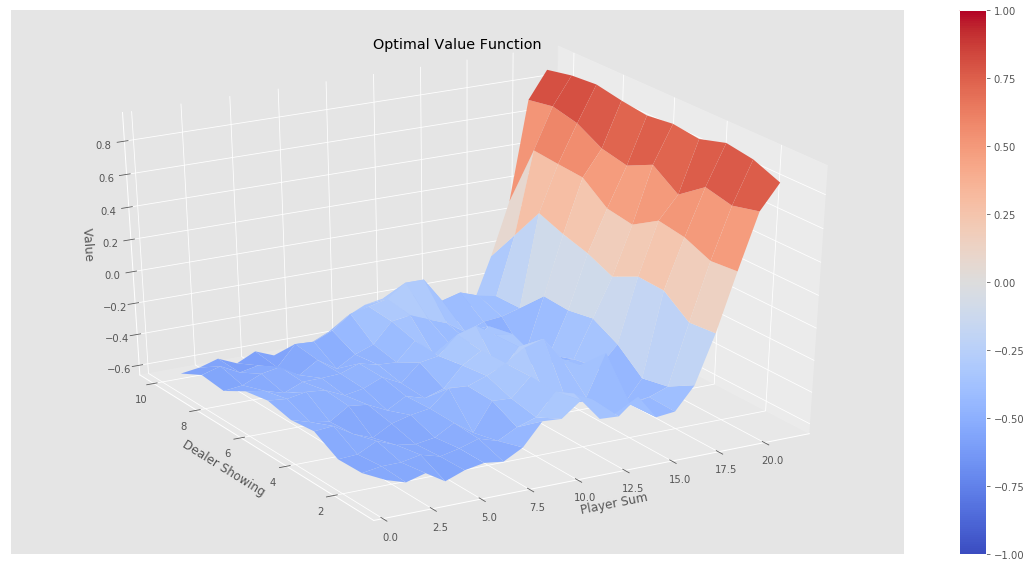

In [65]:
import matplotlib
import numpy as np
import sys

from collections import defaultdict

if "../" not in sys.path:
  sys.path.append("../") 
from easy21game import Easy21
import plotting

matplotlib.style.use('ggplot')

env = Easy21()

def epsilon_greedy_policy(Q, epsilon, nA, Ns,N0):

    def policy_fn(observation):
        curr_epsilon=N0/(N0+Ns[observation])
        A = np.ones(nA, dtype=float) * curr_epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - curr_epsilon)
        return A
    return policy_fn
    
def mc_control(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    
   #Dictionary of returns sum and count
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    Ns=defaultdict(float)
    
    #Dictionary mapping state to action values
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    #Create policy based on Q, epsilon, and number of actions
    policy = epsilon_greedy_policy(Q, epsilon, env.action_space.n, Ns, 100)
    
    for i in range(1, num_episodes + 1):
        
        #if i % 1000 == 0:
        #    print "\rEpisode {}/{}.".format(i, num_episodes)
        #    sys.stdout.flush()
        
        # Generate episode.
        episode = []
        state = env.reset()
        Ns[state] += 1.0
        
        for t in range(100):
            probs = policy(state)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            Ns[next_state] += 1.0
            if done:
                break
            state = next_state

        state_action_pair_in_episode = set([(tuple(x[0]), x[1]) for x in episode])
        for state, action in state_action_pair_in_episode:
            state_action_pair = (state, action)
            #First occurence of state action pair in episode
            first_occurence_idx = next(i for i,x in enumerate(episode)
                                       if x[0] == state and x[1] == action)
           #All rewards since first occurence, discounted
            G = sum([x[2]*(discount_factor**i) for i,x in enumerate(episode[first_occurence_idx:])])
            
            #Average return calculated
            returns_sum[state_action_pair] += G
            returns_count[state_action_pair] += 1.0
            error=G-Q[state][action]
            step=1.0/returns_count[state_action_pair]
            #Q[state][action] = returns_sum[state_action_pair] / returns_count[state_action_pair]
            Q[state][action]+=step*error
        
        #Q dictionary changed implicitly and policy improved
    
    return Q, policy
    
Q, policy = mc_control(env, num_episodes=100000, epsilon=0.1)

def sample_policy(observation):

    score, dealer_score= observation
    return np.array([1.0, 0.0]) if score >= 18 else np.array([0.0, 1.0])
    

V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value

plotting.plot_value_function(V, title="Optimal Value Function")

## 2. SARSA($\lambda$):

In [68]:
Image(url="sarsa_lambda.png")

In [51]:
import os
os.chdir("/Users/yuedong/Downloads/comp767_easy21/")
#%%

from easy21game import Easy21
import numpy as np
from matplotlib import cm
#%%
env = Easy21()

#%%
class Sarsa_Agent:
    def __init__(self, environment, n0, mlambda):
        # n0 is used for defining the variant of the epsilon in the epsilon greedy algorithm
        self.n0=float(n0)
        self.env = environment
        self.mlambda = mlambda
        
        # N(s) is the number of times that state s has been visited
        # N(s,a) is the number of times that action a has been selected from state s.
        self.N = np.zeros((self.env.dealer_space,
                           self.env.player_space, 
                           self.env.nA))
        
        self.Q = np.zeros((self.env.dealer_space,
                           self.env.player_space, 
                           self.env.nA))
        
        self.E = np.zeros((self.env.dealer_space,
                           self.env.player_space, 
                           self.env.nA))
        # Initialise the value function to zero. 
        self.V = np.zeros((self.env.dealer_space,
                           self.env.player_space))
        
        self.count_wins = 0
        self.iterations = 0
    
   # def get_state_number(self, state):
   #     # a state not busted
   #     if state[0]>0 and state[0]<22:
   #         player_idx = state[0]-1
   #     # busted, go to terminal state which is never get updated
   ##     else:
   #         player_idx = 21
   #     dealer_idx=  state[1] - 1  
   #     return player_idx, dealer_idx
    
    def get_state_number(self, state):
        # based on the state returned from environment, 
        # find the index of the states in E,Q,N,V
        player_idx = state[0]-1
        dealer_idx=  state[1] - 1  
        return player_idx, dealer_idx

    # get optimal action based on epsilon-greedy exploration strategy  
    def fixed_epsilon_greedy_action(self, state, epsilon=0.1):
        player_idx, dealer_idx = self.get_state_number(state)
        # action = 0 stick
        # action = 1 hit
        hit = 1
        stick = 0
        # epsilon greedy policy
        if np.random.random() < epsilon:
            r_action = hit if np.random.random()<0.5 else stick
            return r_action
        else:
            action = np.argmax(self.Q[dealer_idx, player_idx, :])
            return action
    
    # abry epsilon based on the assignment with epsilon = N0/(N0 + N(st)
    def var_epsilon_greedy_action(self, state):
        player_idx, dealer_idx = self.get_state_number(state)
        hit = 1
        stick = 0   
        try:
            n_visits = sum(self.N[player_idx, dealer_idx, :])
        except:
            n_visits = 0        


        # epsilon = N0/(N0 + N(st)
        curr_epsilon = self.n0 / (self.n0 + n_visits)

        # epsilon greedy policy
        if np.random.random() < curr_epsilon:
            r_action = hit if np.random.random()<0.5 else stick
            return r_action
        else:
            action = np.argmax(self.Q[player_idx, dealer_idx, :])
            return action
        
        
    def get_action(self, state):
        player_idx, dealer_idx = self.get_state_number(state)
        action = np.argmax(self.Q[dealer_idx, player_idx, :])
        return action
    
    
    def train(self, iterations):        
        
        # Loop episodes
        for episode in range(iterations):
            self.E = np.zeros((self.env.dealer_space,
                               self.env.player_space, self.env.nA))

            # get initial state for current episode
            s = self.env._reset()
            a = self.fixed_epsilon_greedy_action(s)
            a_next = a
            term = False
            
            # Execute until game ends
            while not term:
                # update visits
                player_idx, dealer_idx = self.get_state_number(s)
                self.N[dealer_idx, player_idx, a] += 1
                
                # execute action
                s_next, r, term = self.env._step(a)[0:3]
                player_idx_next, dealer_idx_next = self.get_state_number(s_next)
                q = self.Q[dealer_idx, player_idx, a]
                                
                if not term:
                    # choose next action with epsilon greedy policy
                    a_next = self.fixed_epsilon_greedy_action(s_next)
                    next_q = self.Q[dealer_idx_next, player_idx_next, a_next]
                    delta = r + next_q - q
                else:
                    delta = r - q
                
                self.E[dealer_idx, player_idx, a] += 1
                alpha = 1.0  / (self.N[dealer_idx, player_idx, a])
                update = alpha * delta * self.E
                self.Q += update
                self.E *= self.mlambda

                # reassign s and a
                s = s_next
                a = a_next

            self.count_wins = self.count_wins+1 if r==1 else self.count_wins

        self.iterations += iterations

        # Derive value function
        for d in range(self.env.dealer_space):
            for p in range(self.env.player_space):
                self.V[d,p] = max(self.Q[d, p, :])
                
    def plot_frame(self, ax):
        def get_stat_val(x, y):
            return self.V[x, y]

        X = np.arange(0, self.env.dealer_space, 1)
        Y = np.arange(0, self.env.player_space, 1)
        X, Y = np.meshgrid(X, Y)
        Z = get_stat_val(X, Y)
        #surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
        return surf

('done ', 0, 'step_size', 1000, 'total_episodes', 1000)
('done ', 0, 'step_size', 1000, 'total_episodes', 2000)
('done ', 1, 'step_size', 1000, 'total_episodes', 3000)
('done ', 2, 'step_size', 1000, 'total_episodes', 4000)
('done ', 3, 'step_size', 1000, 'total_episodes', 5000)
('done ', 4, 'step_size', 1000, 'total_episodes', 6000)
('done ', 5, 'step_size', 1000, 'total_episodes', 7000)
('done ', 6, 'step_size', 1000, 'total_episodes', 8000)
('done ', 7, 'step_size', 1000, 'total_episodes', 9000)
('done ', 8, 'step_size', 1000, 'total_episodes', 10000)
('done ', 9, 'step_size', 1000, 'total_episodes', 11000)
('done ', 10, 'step_size', 1000, 'total_episodes', 12000)
('done ', 11, 'step_size', 1000, 'total_episodes', 13000)
('done ', 12, 'step_size', 1000, 'total_episodes', 14000)
('done ', 13, 'step_size', 1000, 'total_episodes', 15000)
('done ', 14, 'step_size', 1000, 'total_episodes', 16000)
('done ', 15, 'step_size', 1000, 'total_episodes', 17000)
('done ', 16, 'step_size', 1000, '

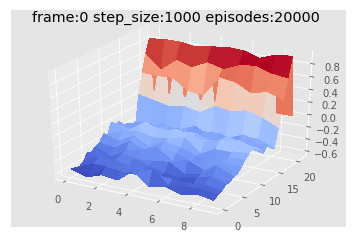

In [78]:
def animate(frame):
    #i = agent.iterations
    step_size = 1000
    #step_size = max(1, step_size)
    #step_size = min(step_size, 2 ** 16)
    agent.train(step_size)

    ax.clear()
    surf =  agent.plot_frame(ax)
    plt.title('frame:%s step_size:%s episodes:%s ' % ( 
                                                      frame, step_size, agent.iterations) )
    # plt.draw()
    fig.canvas.draw()
    print("done ", frame, 'step_size', step_size, 'total_episodes', agent.iterations)
    return surf

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline 

N0 = 100
mlambda = 0.2
agent = Sarsa_Agent(env, N0, mlambda)
fig = plt.figure("N100")
ax = fig.add_subplot(111, projection='3d')

# ani = animation.FuncAnimation(fig, animate, 32, repeat=False)
ani = animation.FuncAnimation(fig, animate, 18, repeat=False)

# note: requires gif writer; swap with plt.show()
ani.save('Sarsa_Agent.gif', writer='imagemagick', fps=3)
# plt.show()

In [80]:
from IPython.display import Image
Image(url="Sarsa_Agent.gif")

## Discussion and Results

The following graph compares different algorithms we used for Easy21. We could see that MC has more spikes than the best SARSA($\lambda$). As discussed in the next block, we noticed that MC perform worse with less episodes at the beginning. Using bootstrapping do help with the performance of the estimation early on. When $\lambda=0$, SARSA($\lambda$) is the same as SARSA(0) and when $\lambda=1$, SARSA($\lambda$) is the same as Monte Carlo methods. As we could confirm from our graph, the intermediate $\lambda$ is the best. With increased $\lambda$, the behavior of SARSA($\lambda$) looks more like Monte Carlo method. In the backward view of SARSA($\lambda$), $\lambda$ controls how fast the eligibility trace decay. When $\lambda$ is bigger, it means we decay the eligibility trace slower. So the earlier visited states will still get updated. In the extreme case when $\lambda=1$, all the states we visited will get updated. And when $\lambda=0$, then only the last state visited will get updated as SARSA(0) does. Moreover, we compared Blackjack with easy21 and we conclude that easy21 is harder to learn than Blackjack. This is because at episode 3000, MC already give good and smooth values for all states and this is not the case in easy21.

In [67]:
Image(url="3000_episodes_with_different_algorithms.png")

In conclusion, Monte Carlo updates use the complete return over the remainder of the episode. Sarsa, on the other hand, uses bootstrapping updates, through which future returns are estimated using the value of the next
state.

Bootstrapping has lower variance, since it depends on the current reward and those in the intermediate steps as opposed to just the final reward, at the cost of some bias. 

Depending on the task, bootstrapping may be a favourable method over MC. For blackjack and its variants (Easy21, for example), the effectiveness of MC depends on the average length of episode per game. In blackjack, these episodes are often very short, allowing MC to work well. In Easy21, the existence of the red cards (that can move overall sum backwards) makes the episodes much longer for which the high variance methods of MC suffer and bootstrapping methods like SARSA do well.